## Zero-Shot Learning Experiments

### Topic classification

Using https://huggingface.co/zero-shot/ 

### 1. Replicate the results from app in code

In [1]:
from transformers import pipeline

In [2]:
classifier = pipeline('zero-shot-classification',
                      model='joeddav/xlm-roberta-large-xnli')

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
sequence = "The Avengers - Hammer Top Besetzung - Top Film endlich war es soweit. Meine Superhelden vereint in einem Film. Ich habe mich besonders auf Robert Downey Jr. und Chris Hemsworth gefreut. Robert stellt Iron Man mit einer Coolness dar, die man nicht überbieten kann. Die Rolle ist perfekt auf ihn zugeschnitten. Chris Hemsworth ist einfach eine Augenweide:-). Loki war auch super. Gegen Mark Ruffalo als Hulk hatte ich meine Bedenken, die wurden dann aber im Film widerlegt. Wenn man die einzelnen Filme vorher gesehen hat und auch die Anspielungen auf 'The Avengers' verstanden hat, ist der Film noch interessanter. Die Story war vorhersehbar, aber trotzdem gut. Was mir am besten gefallen hat, ist das jeder Charakter gleich stark vertreten war. Fazit: Unbedingt anschauen!"
hypothesis_template = 'This text is about {}.' 
labels = "películas, acción, superhéroes, libros"
allow_multi_class = True

In [4]:
result = classifier(sequence, labels,
           hypothesis_template=hypothesis_template,
           multi_class=allow_multi_class)

result

{'sequence': "The Avengers - Hammer Top Besetzung - Top Film endlich war es soweit. Meine Superhelden vereint in einem Film. Ich habe mich besonders auf Robert Downey Jr. und Chris Hemsworth gefreut. Robert stellt Iron Man mit einer Coolness dar, die man nicht überbieten kann. Die Rolle ist perfekt auf ihn zugeschnitten. Chris Hemsworth ist einfach eine Augenweide:-). Loki war auch super. Gegen Mark Ruffalo als Hulk hatte ich meine Bedenken, die wurden dann aber im Film widerlegt. Wenn man die einzelnen Filme vorher gesehen hat und auch die Anspielungen auf 'The Avengers' verstanden hat, ist der Film noch interessanter. Die Story war vorhersehbar, aber trotzdem gut. Was mir am besten gefallen hat, ist das jeder Charakter gleich stark vertreten war. Fazit: Unbedingt anschauen!",
 'labels': ['superhéroes', 'películas', 'acción', 'libros'],
 'scores': [0.9459265470504761,
  0.6354550123214722,
  0.593166172504425,
  0.02965512126684189]}

In [5]:
result["labels"][0], result["scores"][0]

('superhéroes', 0.9459265470504761)

### 2. Apply method to all the sentences from our data

In [6]:
HYPOTHESIS_TEMPLATE = 'This text is about {}.' 
LABELS = "Direct payment, Tax deduction, Credit/guarantee, Technical assistance, Supplies, Fines, Unknown"

def classify_sentence(sentence, labels, allow_multi_class=False, multi_class_thresh=0.5, all_probs=False):
    result = classifier(sentence, labels,
           hypothesis_template=HYPOTHESIS_TEMPLATE,
           multi_class=allow_multi_class)
    
    if all_probs:
        return result["labels"], result["scores"]
    
    if allow_multi_class:
        multi_labels = []
        multi_scores = []
        for i, score in enumerate(result["scores"]):
            if score > multi_class_thresh:
                multi_labels.append(result["labels"][i])
                multi_scores.append(score)
         
        return multi_labels, multi_scores
    
    return result["labels"][0], result["scores"][0]

In [7]:
# True label: guarantee
classify_sentence("Disminuir los riesgos para el inversionista implementando mecanismos de aseguramiento.", LABELS, True)

(['Credit/guarantee'], [0.8358953595161438])

In [8]:
# True label: direct payment
classify_sentence("Los recursos que el Fondo Forestal Mexicano obtenga por el cobro de bienes y servicios ambientales se entregarán directamente a los proveedores de dichos servicios y una parte se destinará a cubrir los costos de esta operación.", LABELS)

('Direct payment', 0.42551904916763306)

In [9]:
# True label: Tax deduction
classify_sentence("Otorgar incentivos fiscales a las plantaciones forestales comerciales, incluyendo incentivos dirigidos a promover la industria ligada a las plantaciones comerciales forestales.", LABELS)

('Tax deduction', 0.4818664789199829)

### Load labeled sentences from 5 countries

In [10]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
sys.path.append("../../../")
from tasks.data_loader.src.utils import *

In [11]:
fname = "../input/allcountries_tagged_sents.json"
data = load_file(fname)

### Filter out badly parsed sentences

In [12]:
missing_ids = []
for document, content in data.items():
    for section in content.values():
        for sid, sentence in section['sentences'].items():
            if 0 <= len(sentence['text']) <= 1:
                missing_ids.append(sid)

print(len(missing_ids))

741


In [13]:
def remove_sents_from_dataset(ids, dataset):
    filtered_dataset = {}
    
    for docid, document in dataset.items():
        filtered_dataset[docid] = {}
        for secid, section in document.items():
            filtered_dataset[docid][secid] = {}
            filtered_dataset[docid][secid]['tags'] = section['tags']
            filtered_dataset[docid][secid]['sentences'] = {}
            for sentid, sentence in section['sentences'].items():
                if sentid not in ids:
                    filtered_dataset[docid][secid]['sentences'][sentid] = sentence
            
    return filtered_dataset

In [14]:
dataset = remove_sents_from_dataset(missing_ids, data)

In [24]:
dataset_map = labeled_sentences_from_dataset(dataset)

### 3. Binary classification

In [15]:
labels = labels_from_dataset(dataset)

In [16]:
label_names = ["not incentives", "incentives"]
binary_labels = list(map(lambda x: "incentives" if x != "Unknown" else "not incentives", labels))

In [17]:
binary_labels.count("incentives"), binary_labels.count("not incentives")

(221, 83)

In [18]:
num_bin_labels = labels_to_numeric(binary_labels, label_names)

In [19]:
num_bin_labels[180:190]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [20]:
def get_counts_per_label(y_true, n_classes):
    """
    Return a map of {label: number of data points with that label} for the given list of labels

    Parameters:
        - y_true: a list of labels (either integer or string)
        - n_classes: (integer) the number of classes
    """
    label_counts = [0] * n_classes
    for label in y_true:
        label_counts[label] += 1
    return label_counts
    
def plot_data_distribution(data, label_names, normalize=True):
    weights = np.array(get_counts_per_label(data, len(label_names)))
    if normalize:
        weights = weights / sum(weights)

    plt.bar(label_names, weights)
    plt.xticks(label_names, rotation=90)
    plt.title("Data Distribution")
    plt.xlabel("Label")
    plt.ylabel("Percentage of label in data")
    plt.show()

    print("Label counts:")
    print(dict(zip(label_names, weights)))
    
def labels_to_numeric(labels, label_names):
    label_map = dict(zip(label_names, range(len(label_names))))
    num_dataset_labels = [label_map[label] for label in labels]
    return num_dataset_labels

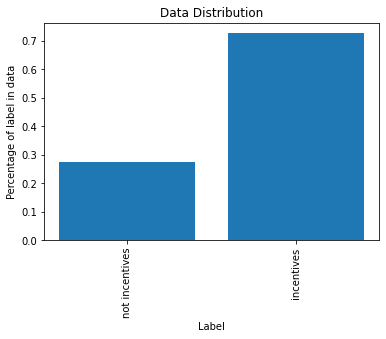

Label counts:
{'not incentives': 0.2730263157894737, 'incentives': 0.7269736842105263}


In [21]:
plot_data_distribution(num_bin_labels, label_names)

In [26]:
LABELS = ", ".join(label_names)
bin_model_preds = []
bin_scores = []
for sentence in tqdm(dataset_map.values()):
    model_pred, score = classify_sentence(sentence['text'], LABELS)
    bin_model_preds.append(model_pred)
    bin_scores.append(score)

100%|██████████| 304/304 [04:14<00:00,  1.20it/s]


In [29]:
bin_preds = labels_to_numeric(bin_model_preds, label_names)
bin_preds[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [30]:
from tasks.evaluate_model.src.model_evaluator import *

In [31]:
evaluator = ModelEvaluator(label_names)

In [33]:
evaluator.update(num_bin_labels, bin_preds)
print("Recall per class:", evaluator.recall)
print("Average weighted precision:", evaluator.avg_precision[1])

Recall per class: [0.01204819 0.94117647]
Average weighted precision: 0.540917487684729


Stored confusion matrix: ../output/binary_class_test_cm.png


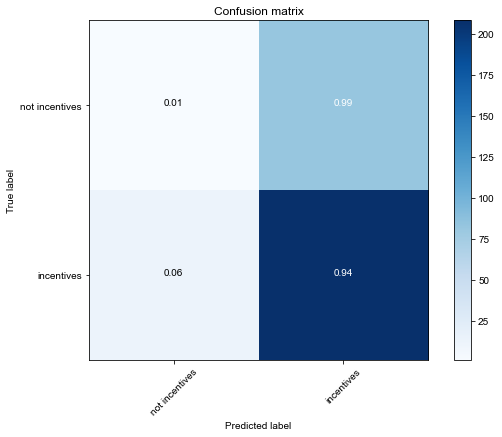

Stored results: ../output/binary_class_test_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
not incentives,0.07,0.01,0.94,0.02
incentives,0.72,0.94,0.01,0.81
Macro avg,0.39,0.48,0.48,0.42
Weighted avg,0.54,0.69,0.27,0.6
Accuracy,-----,-----,-----,0.6875
-----,-----,-----,-----,-----


In [34]:
evaluator.evaluate(num_bin_labels, bin_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="binary_class_test")

In [ ]:
evaluator.plot_precision_recall_curve(num_bin_labels, bin_scores, bin_class=True, store=True, exp_name="binary_class_test")

### 4. Multi-class classification

In [51]:
label_names = ["Direct payment", "Tax deduction", "Credit", "Guarantee", "Technical assistance", "Supplies", "Fine", "Unknown"]
LABELS = ", ".join(label_names)

In [52]:
multi_model_preds = []
multi_scores = []
for sentence in tqdm(dataset_map.values()):
    model_pred, score = classify_sentence(sentence['text'], LABELS)
    multi_model_preds.append(model_pred)
    multi_scores.append(score)

100%|██████████| 304/304 [12:58<00:00,  2.56s/it]


In [53]:
evaluator = ModelEvaluator(label_names)

In [59]:
multi_model_preds[:10], labels[:10]

(['Guarantee',
  'Fine',
  'Guarantee',
  'Fine',
  'Fine',
  'Technical assistance',
  'Fine',
  'Credit',
  'Guarantee',
  'Unknown'],
 ['Direct payment (PES)',
  'Direct payment (PES)',
  'Supplies',
  'Supplies',
  'Supplies',
  'Supplies',
  'Direct payment (PES)',
  'Direct payment (PES)',
  'Supplies',
  'Supplies'])

In [54]:
# Make label names from dataset match label names from prediction (a.k.a make all Direct payments be the same)
updated_labels = []
for label in labels:
    if "(" in label:
        updated_labels.append("Direct payment")
    else:
        updated_labels.append(label)

In [55]:
num_multi_labels = labels_to_numeric(updated_labels, label_names)
num_multi_preds = labels_to_numeric(multi_model_preds, label_names)

Stored confusion matrix: ../output/multi_class_test_cm.png


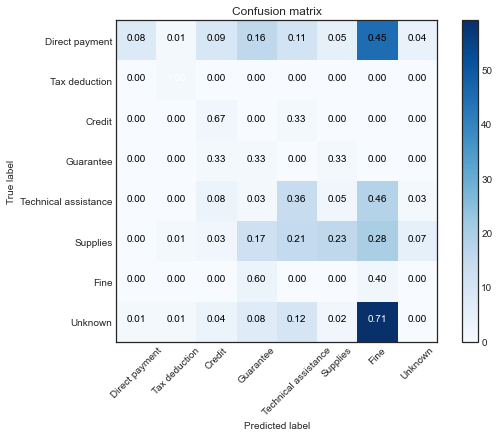

Stored results: ../output/multi_class_test_results.csv


,Precision,Recall (Sensitivity),True negative rate (Specificity),F1-score
Direct payment,0.89,0.08,1,0.15
Tax deduction,0.25,1,0.99,0.4
Credit,0.1,0.67,0.94,0.17
Guarantee,0.03,0.33,0.87,0.05
Technical assistance,0.27,0.36,0.86,0.31
Supplies,0.62,0.23,0.96,0.33
-----,-----,-----,-----,-----
Fine,0.01,0.4,0.53,0.03
Unknown,0,0,0.95,0
Macro avg,0.27,0.38,0.89,0.18


In [56]:
evaluator.evaluate(num_multi_labels, num_multi_preds, 
                   plot_cm=True, normalize=True, 
                   store=True, exp_name="multi_class_test")

Stored Precision-Recall Curve: multi_class_test_prc.png


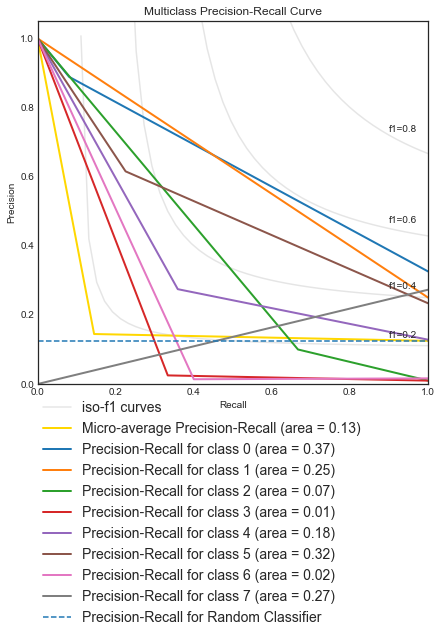

In [57]:
evaluator.plot_precision_recall_curve(num_multi_labels, num_multi_preds, bin_class=False, all_classes=True, store=True, exp_name="multi_class_test")

### Tangent: Separate mutliple labels into a list from JSON file

In [70]:
import json

In [2]:
with open("../input/wri_5countries_tagged_sentences.json", "r") as fjson: 
    jsents = json.load(fjson)

In [20]:
len(jsents), jsents.keys()

(13,
 dict_keys(['2019 ACUERDO por el que se emiten los Lineamientos de Operación del Programa Sembrando Vida', '2020 ACUERDO por el que se emiten las Reglas de Operación del Programa Sembrando Vida, para el ejercicio fiscal 2020', 'Sembrando Vida Brochure', '2020 AVANCES Y RETOS DEL PROGRAMA CRÉDITO GANADERO A LA PALABRA', '2019 ACUERDO por el que se emiten los Lineamientos de Operación del Programa Crédito Ganadero a la Palabra', '2020 REGLAS de Operación del Programa Apoyos para el Desarrollo Forestal Sustentable', '2018 LEY GENERAL DE DESARROLLO FORESTAL SUSTENTABLE', '2013 LEY AMBIENTAL PARA EL DESARROLLO SUSTENTABLE DEL ESTADO DE MICHOACÁN DE OCAMPO', 'Programa Estratégico Forestal para México 2025', '2000 REGLAMENTO DE LA LEY GENERAL DEL EQUILIBRIO ECOLÓGICO Y LA PROTECCIÓNAL AMBIENTE EN MATERIA DE ÁREAS NATURALES PROTEGIDAS', '2000 REGLAMENTO DE LA LEY GENERAL DEL EQUILIBRIO ECOLÓGICO Y LA PROTECCIÓN\nAL AMBIENTE EN MATERIA DE ÁREAS NATURALES PROTEGIDAS', '2007 Decreto Nº 223 -

In [33]:
sentence_tags_dict = {}
new_json = {}

for keydoc, document in jsents.items():
    new_json[keydoc] = {}
    for keysec, section in document.items():
        new_json[keydoc][keysec] = {}
        new_json[keydoc][keysec]['tags'] = section['tags']
        new_json[keydoc][keysec]['sentences'] = {}
        for sentid, sentence in section['sentences'].items():
            new_labels = [label.strip() for label in sentence['labels'].split(", ")]
            new_json[keydoc][keysec]['sentences'][sentid] = {'text': sentence['text'], 'labels': new_labels}

In [36]:
len(new_json), new_json.keys()

(13,
 dict_keys(['2019 ACUERDO por el que se emiten los Lineamientos de Operación del Programa Sembrando Vida', '2020 ACUERDO por el que se emiten las Reglas de Operación del Programa Sembrando Vida, para el ejercicio fiscal 2020', 'Sembrando Vida Brochure', '2020 AVANCES Y RETOS DEL PROGRAMA CRÉDITO GANADERO A LA PALABRA', '2019 ACUERDO por el que se emiten los Lineamientos de Operación del Programa Crédito Ganadero a la Palabra', '2020 REGLAS de Operación del Programa Apoyos para el Desarrollo Forestal Sustentable', '2018 LEY GENERAL DE DESARROLLO FORESTAL SUSTENTABLE', '2013 LEY AMBIENTAL PARA EL DESARROLLO SUSTENTABLE DEL ESTADO DE MICHOACÁN DE OCAMPO', 'Programa Estratégico Forestal para México 2025', '2000 REGLAMENTO DE LA LEY GENERAL DEL EQUILIBRIO ECOLÓGICO Y LA PROTECCIÓNAL AMBIENTE EN MATERIA DE ÁREAS NATURALES PROTEGIDAS', '2000 REGLAMENTO DE LA LEY GENERAL DEL EQUILIBRIO ECOLÓGICO Y LA PROTECCIÓN\nAL AMBIENTE EN MATERIA DE ÁREAS NATURALES PROTEGIDAS', '2007 Decreto Nº 223 -

In [51]:
with open("allcountries_tagged_sents.json", "w") as wjson:
    json.dump(new_json, wjson)

In [65]:
pwd()

'/Users/dafirebanks/Projects/policy-data-analyzer/tasks/augment_data/notebooks'

In [53]:
data = load_file("allcountries_tagged_sents.json")

In [54]:
dataset_map = labeled_sentences_from_dataset(data)

In [67]:
dataset_map['1']

{'text': 'Generar empleo y garantizara la población campesina el bienestar y su participación e incorporación en el desarrollo nacional, y fomentará la actividad agropecuaria y forestal para el óptimo uso de la tierra, con obras de infraestructura, insumos, créditos, servicios de capacitación y asistencia técnica',
 'labels': ['Direct payment (PES)', 'Credit', 'Technical assistance']}

In [68]:
dataset_labels = labels_from_dataset(data)
dataset_labels[:10]

['Direct payment (PES)',
 'Direct payment (PES)',
 'Supplies',
 'Supplies',
 'Supplies',
 'Supplies',
 'Direct payment (PES)',
 'Direct payment (PES)',
 'Supplies',
 'Supplies']

In [69]:
numeric_labels = numeric_labels_from_dataset(data)
numeric_labels[:10]

[3, 3, 6, 6, 6, 6, 3, 3, 6, 6]